In [14]:
import torch
import pandas as pd
import torch.nn as nn
from joblib import dump
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ------------------------------
# 读取数据并预处理
# ------------------------------
# 读取Excel文件
file_path = "hls4ml_results_filtered.xlsx"
data = pd.read_excel(file_path, header=None)

# 去除第一行（表头）
data = data.iloc[1:].reset_index(drop=True)

# 注意：假设 Excel 文件中总共有 14 列，
#        前 7 列作为输入，后 7 列作为输出，
#        而输出中的第8列和第9列（0基索引为7和8）带有百分号格式。
# 下面转换第8列和第9列的数据：
for col in [7, 8]:
    data.iloc[:, col] = data.iloc[:, col].apply(
        lambda x: float(str(x).replace('%', '').strip()) / 100 if '%' in str(x) else float(x)
    )

# 提取输入（前7列）和输出（后7列）
X = data.iloc[:, :7].values
y = data.iloc[:, 7:14].values

# ------------------------------
# 数据标准化与划分训练/测试集
# ------------------------------
# 标准化（分别对输入和输出）
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 保存 scaler 对象到文件中
dump(scaler_X, "scaler_X.pkl")
dump(scaler_y, "scaler_y.pkl")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test , dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test  = torch.tensor(y_test , dtype=torch.float32)

# ------------------------------
# 定义神经网络模型
# ------------------------------
class ImprovedFCnet(nn.Module):
    def __init__(self, hidden_dim=640, dropout_rate=0.2):
        super(ImprovedFCnet, self).__init__()

        # 第一层：输入7维到hidden_dim，高维特征提取
        self.fc1 = nn.Linear(7, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        # 第二层：降维到hidden_dim//2
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        # 第三层：降回7维
        self.fc3 = nn.Linear(hidden_dim // 2, 7)
        # Dropout层，防止过拟合
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # 保存输入，用于后续残差连接（当输入输出维度一致时）
        residual = x
        
        # 第一层：线性 -> BN -> ReLU -> Dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # 第二层：线性 -> BN -> ReLU -> Dropout
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        # 第三层：线性
        x = self.fc3(x)
        
        # 如果输入维度与输出维度相同，则加上残差连接
        if residual.shape[-1] == x.shape[-1]:
            x = x + residual
        return x

# 实例化模型
model = ImprovedFCnet()

# ------------------------------
# 设置损失函数和优化器
# ------------------------------
criterion = nn.MSELoss()  # 均方误差损失函数
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam 优化器

# ------------------------------
# 训练模型
# ------------------------------
epochs = 600
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# ------------------------------
# 测试模型
# ------------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

# 反标准化输出，便于解释结果
predictions = scaler_y.inverse_transform(predictions.numpy())
y_test_original = scaler_y.inverse_transform(y_test.numpy())

# ------------------------------
# 计算每一列的 R² 和 MSE
# ------------------------------
print("\n每一列的 R² 和 MSE:")
for i in range(7):
    mse = mean_squared_error(y_test_original[:, i], predictions[:, i])
    r2 = r2_score(y_test_original[:, i], predictions[:, i])
    print(f"第 {i + 1} 列 - MSE: {mse:.4f}, R²: {r2:.4f}")

# ------------------------------
# 保存模型
# ------------------------------
model_path = "resnet_hls4ml.pth"
torch.save(model.state_dict(), model_path)
print(f"\n模型已保存到 {model_path}")

Epoch [10/600], Loss: 0.3569
Epoch [20/600], Loss: 0.2356
Epoch [30/600], Loss: 0.1937
Epoch [40/600], Loss: 0.1738
Epoch [50/600], Loss: 0.1606
Epoch [60/600], Loss: 0.1510
Epoch [70/600], Loss: 0.1393
Epoch [80/600], Loss: 0.1344
Epoch [90/600], Loss: 0.1304
Epoch [100/600], Loss: 0.1225
Epoch [110/600], Loss: 0.1201
Epoch [120/600], Loss: 0.1174
Epoch [130/600], Loss: 0.1114
Epoch [140/600], Loss: 0.1073
Epoch [150/600], Loss: 0.1034
Epoch [160/600], Loss: 0.0997
Epoch [170/600], Loss: 0.0945
Epoch [180/600], Loss: 0.0883
Epoch [190/600], Loss: 0.0862
Epoch [200/600], Loss: 0.0785
Epoch [210/600], Loss: 0.0774
Epoch [220/600], Loss: 0.0714
Epoch [230/600], Loss: 0.0657
Epoch [240/600], Loss: 0.0651
Epoch [250/600], Loss: 0.0611
Epoch [260/600], Loss: 0.0587
Epoch [270/600], Loss: 0.0575
Epoch [280/600], Loss: 0.0552
Epoch [290/600], Loss: 0.0525
Epoch [300/600], Loss: 0.0543
Epoch [310/600], Loss: 0.0496
Epoch [320/600], Loss: 0.0473
Epoch [330/600], Loss: 0.0455
Epoch [340/600], Lo

In [10]:
import numpy as np

# 加载模型
model = ImprovedFCnet()
model.load_state_dict(torch.load("resnet_hls4ml.pth"))
model.eval()

# 给定输入数据
input_data = np.array([[10, 0, 14, 7, 1, 0.00, 0.00]])

# 标准化
input_data_scaled = scaler_X.transform(input_data)
input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32)

# 模型预测
with torch.no_grad():
    prediction_scaled = model(input_tensor).numpy()

# 反标准化
prediction = scaler_y.inverse_transform(prediction_scaled)

formatted_prediction = []

# 遍历每一列输出
for i, value in enumerate(prediction[0]):
    if i < 2:
        # 前两个输出以百分比形式（保留两位小数）
        formatted_prediction.append(f"{value * 100:.2f}%")
    else:
        # 其余输出去掉科学计数法（保留两位小数）
        formatted_prediction.append(f"{value:.2f}")

# 打印格式化后的结果
print("预测结果:", formatted_prediction)
# 应为['80.98%', '75.53%', '44', '634', '142', '106', '465']

预测结果: ['81.11%', '73.39%', '44.03', '635.43', '136.87', '102.36', '244.72']


In [15]:
# ------------------------------
# 可视化分析
# ------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 设置Seaborn样式
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 定义输出列名称（根据实际数据修改）
output_columns = [
    'python模型准确率',
    'hls4ml模型准确率',
    'BRAM占用率',
    'DSP占用率',
    'FF占用率',
    'LUT占用率',
    '延迟(us)'
]

# 创建可视化结果保存目录
import os
os.makedirs("visualization", exist_ok=True)

# 对每个输出维度进行分析
for i, col_name in enumerate(output_columns):
    # 获取当前列的预测值和真实值
    y_true = y_test_original[:, i]
    y_pred = predictions[:, i]
    residuals = y_pred - y_true
    
    # ------------------------------
    # 散点图：真实值 vs 预测值
    # ------------------------------
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    
    # 绘制完美预测对角线
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    plt.title(f"{col_name}\n真实值 vs 预测值 (R²={r2_score(y_true, y_pred):.2f})")
    plt.xlabel("真实值")
    plt.ylabel("预测值")
    plt.savefig(f"visualization/scatter_{col_name}.png", bbox_inches='tight')
    plt.close()

    # ------------------------------
    # 残差图：真实值 vs 残差
    # ------------------------------
    plt.figure(figsize=(10, 6))
    sns.residplot(x=y_true, y=y_pred, lowess=True, 
                 line_kws={'color': 'red', 'lw': 2},
                 scatter_kws={'alpha': 0.6})
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.title(f"{col_name}\n残差分布 (MAE={mean_absolute_error(y_true, y_pred):.2f})")
    plt.xlabel("真实值")
    plt.ylabel("残差（预测值 - 真实值）")
    plt.savefig(f"visualization/residuals_{col_name}.png", bbox_inches='tight')
    plt.close()

    # ------------------------------
    # 误差分布直方图
    # ------------------------------
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=20)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f"{col_name}\n误差分布（均值={residuals.mean():.2f}，标准差={residuals.std():.2f}）")
    plt.xlabel("预测误差")
    plt.ylabel("频数")
    plt.savefig(f"visualization/error_dist_{col_name}.png", bbox_inches='tight')
    plt.close()
   
print("可视化结果已保存至 visualization 目录")

可视化结果已保存至 visualization 目录


In [3]:
import os
import math
from PIL import Image

# 定义需要合并的列（排除'python模型准确率'）
output_columns = [
    'python模型准确率',
    'hls4ml模型准确率',
    'BRAM占用率',
    'DSP占用率',
    'FF占用率',
    'LUT占用率',
    '延迟(us)'
]
columns_to_merge = [col for col in output_columns if col != 'python模型准确率']

def merge_images_grid(image_paths, grid_cols=2, bg_color=(255, 255, 255)):
    """
    将指定路径的图片列表按网格组合成一张图片，grid_cols 指定每行的图片数量。
    """
    # 加载所有图片
    images = [Image.open(path) for path in image_paths if os.path.exists(path)]
    if not images:
        return None

    # 为了排版简单，这里采用统一大小：取所有图片中宽和高的最大值
    widths, heights = zip(*(img.size for img in images))
    max_width = max(widths)
    max_height = max(heights)

    # 计算行数
    grid_rows = math.ceil(len(images) / grid_cols)

    # 创建一张大图，初始背景为白色（可根据需要调整背景颜色）
    merged_width = grid_cols * max_width
    merged_height = grid_rows * max_height
    merged_image = Image.new('RGB', (merged_width, merged_height), color=bg_color)

    # 将每张图片粘贴到对应位置
    for idx, img in enumerate(images):
        row = idx // grid_cols
        col = idx % grid_cols
        # 如果图片尺寸小于（max_width, max_height），可调整粘贴位置使之居中
        x_offset = col * max_width + (max_width - img.size[0]) // 2
        y_offset = row * max_height + (max_height - img.size[1]) // 2
        merged_image.paste(img, (x_offset, y_offset))
    return merged_image

# 对每种图像类型（散点图、残差图、误差直方图）进行合并
for plot_type in ['scatter', 'residuals', 'error_dist']:
    # 构造图片路径列表，例如 "visualization/scatter_hls4ml模型准确率.png"
    image_paths = [os.path.join("visualization", f"{plot_type}_{col}.png")
                   for col in columns_to_merge]
    merged_img = merge_images_grid(image_paths, grid_cols=2)
    if merged_img:
        merged_img_path = os.path.join("visualization", f"merged_{plot_type}.png")
        merged_img.save(merged_img_path)
        print(f"{merged_img_path} 合并成功")
    else:
        print(f"未找到 {plot_type} 类型的图片")

visualization\merged_scatter.png 合并成功
visualization\merged_residuals.png 合并成功
visualization\merged_error_dist.png 合并成功


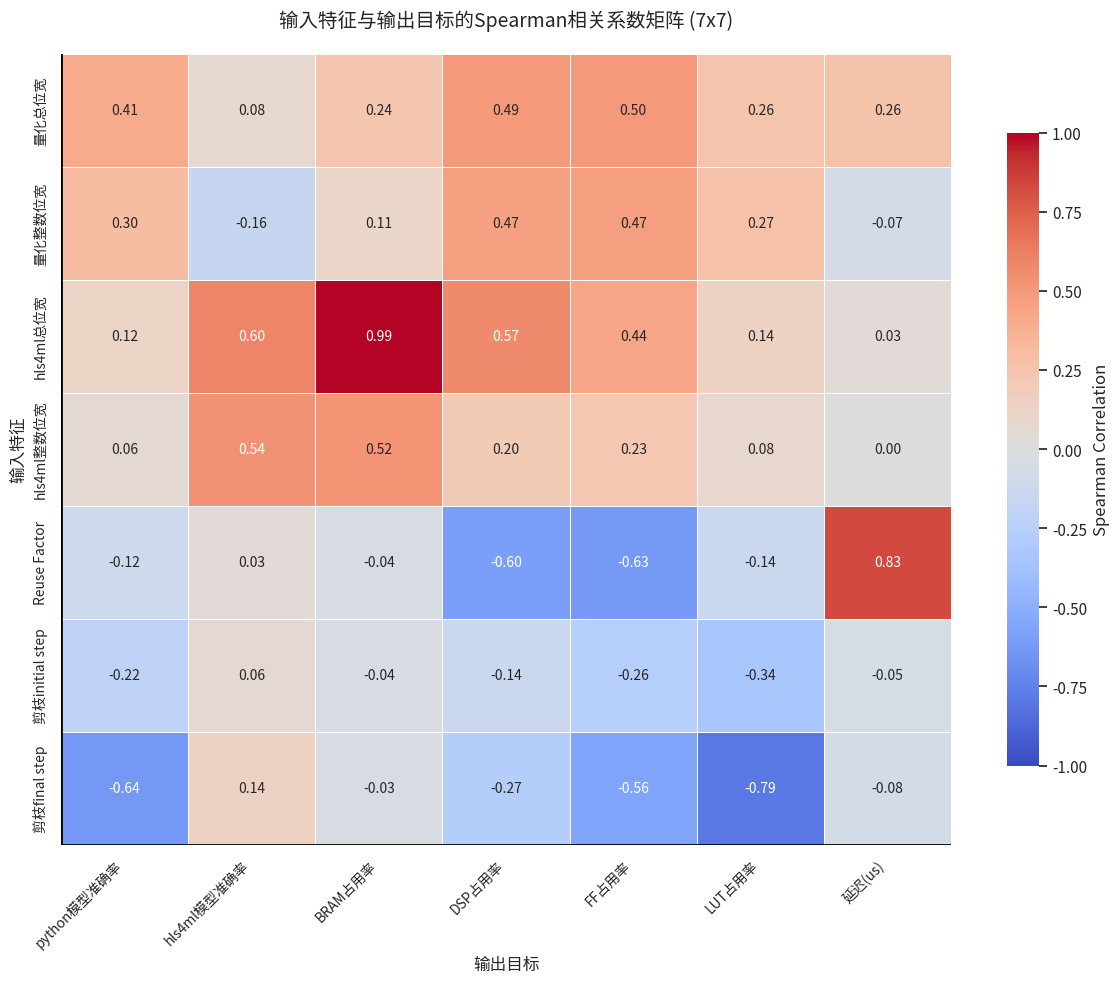

In [16]:
from scipy.stats import spearmanr

# 重新读取原始数据（未标准化的）
original_data = pd.read_excel(file_path, header=None).iloc[1:].reset_index(drop=True)

# 处理百分号列（保持与之前一致）
for col in [7, 8]:
    original_data.iloc[:, col] = original_data.iloc[:, col].apply(
        lambda x: float(str(x).replace('%', '').strip()) / 100 if '%' in str(x) else float(x)
    )

# 定义列名（确保与数据对齐）
input_columns = [
    '量化总位宽', '量化整数位宽', 'hls4ml总位宽',
    'hls4ml整数位宽', 'Reuse Factor', '剪枝initial step', '剪枝final step'
]
output_columns = [
    'python模型准确率', 'hls4ml模型准确率', 'BRAM占用率',
    'DSP占用率', 'FF占用率', 'LUT占用率', '延迟(us)'
]

# 直接构建完整DataFrame（确保输入输出维度一致）
full_df = pd.DataFrame(
    original_data.values,
    columns=input_columns + output_columns
)

# ------------------------------
# 计算Spearman相关系数矩阵
# ------------------------------
corr_matrix, _ = spearmanr(full_df[input_columns + output_columns], axis=0)

# 创建带行列标签的DataFrame
corr_df = pd.DataFrame(
    corr_matrix,
    index=input_columns + output_columns,
    columns=input_columns + output_columns
)

# 提取输入特征与输出目标之间的7x7子矩阵
input_output_corr = corr_df.loc[input_columns, output_columns]

# ------------------------------
# 可视化7x7相关系数矩阵
# ------------------------------
plt.figure(figsize=(12, 10))

# 使用annot_kws调整字号，mask参数聚焦输入-输出关系
sns.heatmap(
    input_output_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 10},
    cbar_kws={"label": "Spearman Correlation", "shrink": 0.8},
    vmin=-1, vmax=1  # 固定颜色范围
)

# 添加分隔线突出显示区域
plt.axvline(x=0, color='black', lw=2)
plt.axhline(y=len(input_columns), color='black', lw=2)

# 标签设置
plt.title("输入特征与输出目标的Spearman相关系数矩阵 (7x7)", fontsize=14, pad=20)
plt.xlabel("输出目标", fontsize=12)
plt.ylabel("输入特征", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# 保存图像
plt.tight_layout()
plt.savefig("visualization/7x7_correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()